<a href="https://colab.research.google.com/github/Soham-Kumar/vehicle_counting/blob/main/yolo_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
HOME = os.getcwd()
print(HOME)
!cd {HOME}

/content


In [6]:
source_video_path = f"{HOME}/traffic_flow.mp4"

## Installing YOLOv8

In [7]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.4/78.2 GB disk)


In [8]:
!cd {HOME}

## Installing ByteTrack

In [9]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [10]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Supervision

In [11]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [12]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Loading pre-trained YOLOv8 model

In [13]:
# settings
MODEL = "yolov8x.pt"

from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 131M/131M [00:00<00:00, 210MB/s]
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients


## Doing prediction for a single frame
Supervision has a built in method to read frames, into the memory, one by one from the video, named "get_video_frames_generator", which needs the attribute of the path of the video. https://github.com/roboflow/supervision/blob/fa6238dbc4d9cddfc029c4c2cdf1c553dbd6d37a/supervision/utils/video.py#L118


Completing all the needed things on one frame, we can put that code inside the loop: "for frame in frame_generator:"


'model' is a pre-trained YOLO model, and it returns a tensor that needs to be converted to numpy array for inputting to Supervision.


BoxAnnotator class from Supervision is used to draw bounding boxes on an image using detections provided.
https://github.com/roboflow/supervision/blob/fa6238dbc4d9cddfc029c4c2cdf1c553dbd6d37a/supervision/detection/annotate.py#L11




0: 384x640 1 person, 17 cars, 1 bus, 6 trucks, 201.3ms
Speed: 3.3ms preprocess, 201.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


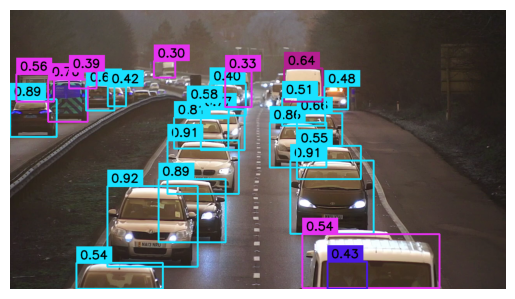

In [14]:
import matplotlib.pyplot as plt

frame_generator = get_video_frames_generator(source_video_path)

# Getting the first frame
iterator = iter(frame_generator)
frame = next(iterator)

detection = model(frame)[0]


detection_sup = Detections(
    xyxy = detection.boxes.xyxy.cpu().numpy(),
    confidence = detection.boxes.conf.cpu().numpy(),
    class_id = detection.boxes.cls.cpu().numpy().astype(int)
)


# Box annotator
box_annotater = BoxAnnotator(color = ColorPalette(), thickness = 4,  text_thickness = 2, text_scale = 1)
frame = box_annotater.annotate(frame = frame, detections = detection_sup)

# Showing the image
plt.imshow(frame)
plt.axis("off")
plt.show()

## Detection for a complete video

The task done above on one frame needs to be put in a for loop iterating over all the frames, and then the annotated frames need to be sewn back into annotated video.

In [19]:
from supervision.video.dataclasses import VideoInfo
from supervision.video.sink import VideoSink
from tqdm.notebook import tqdm

frame_generator = get_video_frames_generator(source_video_path)


# Box annotator
box_annotater = BoxAnnotator(color = ColorPalette(), thickness = 4,  text_thickness = 2, text_scale = 1)
frame = box_annotater.annotate(frame = frame, detections = detection_sup)


video_info = VideoInfo.from_video_path(source_video_path)
target_video_path = f"{HOME}/vehicle-counting-pre-result.mp4"


video_info = VideoInfo.from_video_path(source_video_path)
with VideoSink(target_video_path, video_info) as sink:
  for frame in tqdm(frame_generator, total = video_info.total_frames):
    detection = model(frame)[0]
    detection_sup = Detections(
        xyxy = detection.boxes.xyxy.cpu().numpy(),
        confidence = detection.boxes.conf.cpu().numpy(),
        class_id = detection.boxes.cls.cpu().numpy().astype(int)
    )

    # Box annotator
    box_annotater = BoxAnnotator(color = ColorPalette(), thickness = 4,  text_thickness = 2, text_scale = 1)
    frame = box_annotater.annotate(frame = frame, detections = detection_sup)

    sink.write_frame(frame)

  0%|          | 0/3600 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 384x640 2 persons, 21 cars, 4 trucks, 30.5ms
Speed: 2.0ms preprocess, 30.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 23 cars, 4 trucks, 31.1ms
Speed: 1.9ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 24 cars, 3 trucks, 30.0ms
Speed: 2.0ms preprocess, 30.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 24 cars, 3 trucks, 31.5ms
Speed: 2.1ms preprocess, 31.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 24 cars, 4 trucks, 30.6ms
Speed: 1.9ms preprocess, 30.6ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 22 cars, 4 trucks, 31.5ms
Speed: 2.0ms preprocess, 31.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 22 cars, 4 trucks, 30.9ms
Speed: 2.0ms preprocess, 

## Adding ByteTracker to implement tracking and Supervision fopr counting

### Tracking Utils

Code for mitigating the differences in the output of YOLOv8 and the input for ByteTracker.
*****

*****

In [15]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

Adding the loacation of line, crossing which we'll count that the vehicle is counted.

In [22]:
# settings
LINE_START = Point(50, 1500)
LINE_END = Point(3840-50, 1500)

VideoInfo.from_video_path(source_video_path)
TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result.mp4"

In [27]:
from tqdm.notebook import tqdm


# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(source_video_path)
# create frame generator
generator = get_video_frames_generator(source_video_path)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in [2, 3, 5, 7] for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/3600 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 384x640 2 persons, 21 cars, 4 trucks, 34.8ms
Speed: 1.9ms preprocess, 34.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 persons, 23 cars, 4 trucks, 31.0ms
Speed: 2.0ms preprocess, 31.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 24 cars, 3 trucks, 31.2ms
Speed: 1.9ms preprocess, 31.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 24 cars, 3 trucks, 31.3ms
Speed: 1.9ms preprocess, 31.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 24 cars, 4 trucks, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 22 cars, 4 trucks, 31.6ms
Speed: 2.0ms preprocess, 31.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 22 cars, 4 trucks, 36.0ms
Speed: 2.0ms preprocess, 